
# HLD - Hilbert Lattice Diagram: A Hands‑On Guide

This notebook gives a **detailed, example‑driven tour** of the Hilbert Lattice Diagram (HLD) and shows how to extract insight from it quickly — across **qubits and qudits**, **entangled and separable** states, and **diverse patterns** (coherence, symmetry, excitation structure).

**What HLD encodes**

- **Brightness** \(\to |c_i|\): amplitude magnitude (probability mass visualization)
- **Hue (color)** \(\to \arg(c_i)\): complex phase
- **Rows** \(\to\) a chosen **grouping of basis states** (e.g., excitation/Hamming weight, parity, or a custom rule)
- **Columns** \(\to\) an **ordering** within each row (e.g., lexicographic)

We'll use HLD to read off structure like **which excitation subspaces are occupied**, whether **phases align** within a subspace (coherence), and whether **amplitude is concentrated** in specific motifs (entanglement/product patterns).



## 0. Setup

Run the cell below to import the HLD library and helpers. If `hld` isn't installed locally, this cell will try to install it from PyPI.


In [1]:

# If HLD isn't installed, try to install it (comment out if you manage dependencies externally).
try:
    from hld import plot_hld, compute_hld_metrics, analyze_and_plot_hld
except Exception as e:
    print("HLD not found. Attempting a pip install...")
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "hld"])
    from hld import plot_hld, compute_hld_metrics, analyze_and_plot_hld

import numpy as np
import math

def normalize(vec: np.ndarray) -> np.ndarray:
    vec = np.asarray(vec, dtype=complex).reshape(-1)
    nrm = np.linalg.norm(vec)
    if nrm == 0:
        raise ValueError("Zero vector cannot be normalized.")
    return vec / nrm

def dim_size(dims):
    s = 1
    for d in dims:
        s *= int(d)
    return s

def idx(*levels, dims):
    """Map a tuple of levels to a flat index for the given dims (row-major order)."""
    L = list(map(int, levels))
    D = list(map(int, dims))
    if len(L) != len(D):
        raise ValueError("levels and dims length mismatch")
    out = 0
    for i, (li, di) in enumerate(zip(L, D)):
        if not (0 <= li < di):
            raise ValueError(f"level {li} is out of range for subsystem dim {di}")
        out = out * di + li
    return out

def basis(levels, dims):
    """Return |levels> as a statevector for the given dims."""
    n = dim_size(dims)
    v = np.zeros(n, dtype=complex)
    v[idx(*levels, dims=dims)] = 1.0
    return v

def kron(*states):
    """Kronecker product of vectors (in order)."""
    out = np.array([1.0+0j])
    for s in states:
        out = np.kron(out, np.asarray(s, dtype=complex))
    return out

def phases_ramp(dims, ramp_per_subsystem=None):
    """Create a pure state with a smooth phase ramp across computational basis states."""
    if ramp_per_subsystem is None:
        ramp_per_subsystem = [1.0] * len(dims)
    n = dim_size(dims)
    state = np.zeros(n, dtype=complex)
    # Loop all basis tuples
    for flat in range(n):
        # Decode flat index -> tuple
        tuple_levels = []
        rem = flat
        for d in dims[::-1]:
            tuple_levels.append(rem % d)
            rem //= d
        tuple_levels = tuple_levels[::-1]
        phase = sum(ramp_per_subsystem[i] * tuple_levels[i] for i in range(len(dims)))
        state[flat] = np.exp(1j * 2 * np.pi * phase / max(dims))
    return normalize(state)



## 1. Reading an HLD at a Glance

- **Row occupancy** immediately shows **which subspaces** are populated (e.g., excitation \(W\) layers for qubits).
- **Uniform hue within a row** suggests **phase alignment** (high intra‑row coherence).
- **Alternating/striped hue** indicates **phase structure** that may cancel or interfere.
- **Sparse bright cells** with just a few populated columns often indicate **product‑like** or **cat‑like** states.



## 2. Qubits: Product vs. Entangled

We'll start with **two‑qubit** states to build intuition.


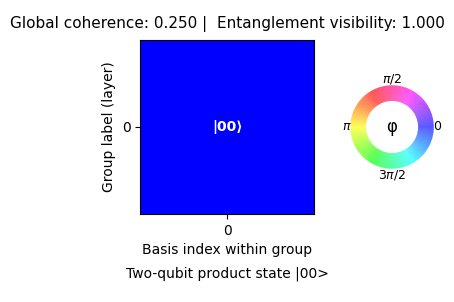

Row probabilities (product): {0: 1.0, 1: 0.0, 2: 0.0}


In [2]:

# 2.1 Product state |00>
dims = [2, 2]
psi_prod = basis((0,0), dims=dims)
plot_hld(psi_prod, dims=dims, show_metrics=True, theme="light", caption="Two-qubit product state |00>")
m_prod = compute_hld_metrics(psi_prod, dims=dims)
print("Row probabilities (product):", m_prod.get("row_probabilities"))


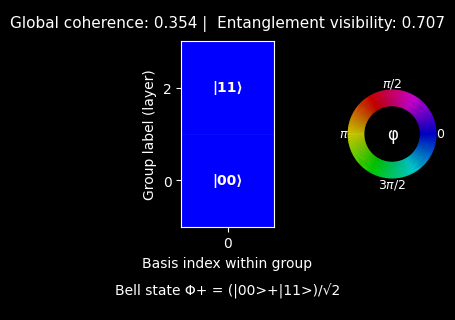

Row probabilities (Bell): {0: 0.5000000000000001, 1: 0.0, 2: 0.5000000000000001}
Entanglement visibility (heuristic): 0.7071067811865476


In [3]:

# 2.2 Bell state (maximally entangled): (|00> + |11>) / sqrt(2)
psi_bell = normalize(basis((0,0), dims=[2,2]) + basis((1,1), dims=[2,2]))
plot_hld(psi_bell, dims=[2,2], show_metrics=True, theme="dark", caption="Bell state Φ+ = (|00>+|11>)/√2")
m_bell = compute_hld_metrics(psi_bell, dims=[2,2])
print("Row probabilities (Bell):", m_bell.get("row_probabilities"))
print("Entanglement visibility (heuristic):", m_bell.get("entanglement_visibility_index"))


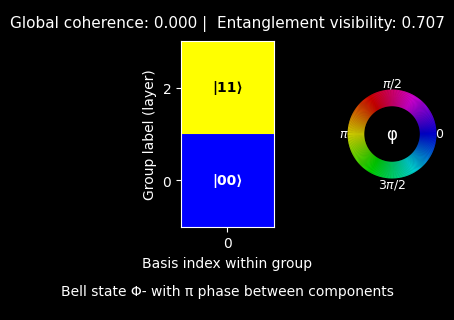

In [4]:

# 2.3 Bell state with a relative phase: (|00> - |11>) / sqrt(2)
psi_bell_phase = normalize(basis((0,0), dims=[2,2]) - basis((1,1), dims=[2,2]))
plot_hld(psi_bell_phase, dims=[2,2], theme="dark", show_metrics=True, caption="Bell state Φ- with π phase between components")



## 3. Three Qubits: GHZ and W

- **GHZ(3)**: \((|000\rangle + |111\rangle)/\sqrt{2}\) → two bright cells in the \(W=0\) and \(W=3\) rows.
- **W(3)**: \((|001\rangle + |010\rangle + |100\rangle)/\sqrt{3}\) → three bright cells in the \(W=1\) row.


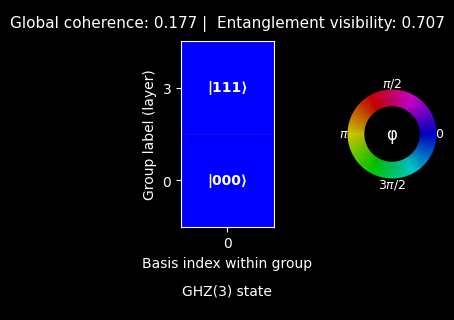

Row probabilities (GHZ3): {0: 0.5000000000000001, 1: 0.0, 2: 0.0, 3: 0.5000000000000001}


In [5]:

# 3.1 GHZ(3)
dims = [2,2,2]
psi_ghz3 = normalize(basis((0,0,0), dims=dims) + basis((1,1,1), dims=dims))
plot_hld(psi_ghz3, dims=dims, show_metrics=True, caption="GHZ(3) state")
m_ghz3 = compute_hld_metrics(psi_ghz3, dims=dims)
print("Row probabilities (GHZ3):", m_ghz3.get("row_probabilities"))


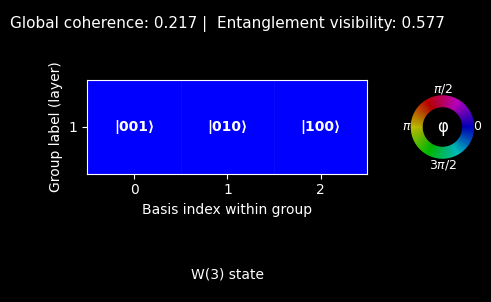

Row probabilities (W3): {0: 0.0, 1: 1.0000000000000002, 2: 0.0, 3: 0.0}
Intra-row coherence (W row): {0: nan, 1: 1.0, 2: nan, 3: nan}


In [6]:

# 3.2 W(3)
psi_w3 = normalize(basis((0,0,1), dims=[2,2,2]) + basis((0,1,0), dims=[2,2,2]) + basis((1,0,0), dims=[2,2,2]))
plot_hld(psi_w3, dims=[2,2,2], show_metrics=True, caption="W(3) state")
m_w3 = compute_hld_metrics(psi_w3, dims=[2,2,2])
print("Row probabilities (W3):", m_w3.get("row_probabilities"))
print("Intra-row coherence (W row):", m_w3.get("intra_row_coherence"))



## 4. Qudits: Beyond Qubits

HLD supports **arbitrary local dimensions** via `dims`. Below we explore **qutrit‑qutrit** and **qubit‑qutrit** systems.

**Tip:** For qudits, the default grouping may not be "Hamming weight". You can still use HLD to reveal amplitude/phase structure across rows defined by **custom groupings**.


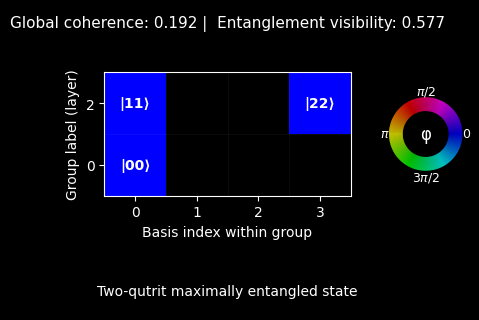

Row probabilities (qutrit Bell-like): {0: 0.3333333333333334, 1: 0.0, 2: 0.3333333333333334, 3: 0.0, 4: 0.3333333333333334}
Entanglement visibility (heuristic): 0.5773502691896258


In [7]:

# 4.1 Maximally entangled two‑qutrit state: (|00> + |11> + |22>) / sqrt(3)
dims = [3,3]
psi_qutrit_bell = normalize(basis((0,0), dims=dims) + basis((1,1), dims=dims) + basis((2,2), dims=dims))
plot_hld(psi_qutrit_bell, dims=dims, show_metrics=True, caption="Two‑qutrit maximally entangled state")
m_q3 = compute_hld_metrics(psi_qutrit_bell, dims=dims)
print("Row probabilities (qutrit Bell-like):", m_q3.get("row_probabilities"))
print("Entanglement visibility (heuristic):", m_q3.get("entanglement_visibility_index"))


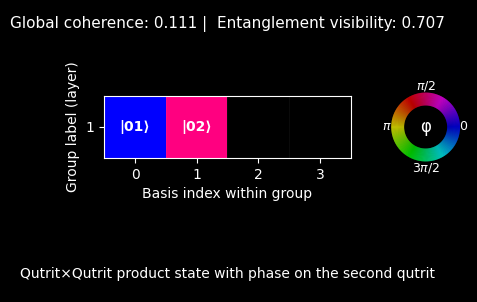

In [8]:

# 4.2 Product state in 3×3: |0>⊗(|1> + e^{iπ/2}|2>)/√2
dims = [3,3]
psi_qutrit_prod = kron(basis((0,), dims=[3]), normalize(basis((1,), dims=[3]) + 1j*basis((2,), dims=[3])))
plot_hld(psi_qutrit_prod, dims=dims, show_metrics=True, caption="Qutrit×Qutrit product state with phase on the second qutrit")


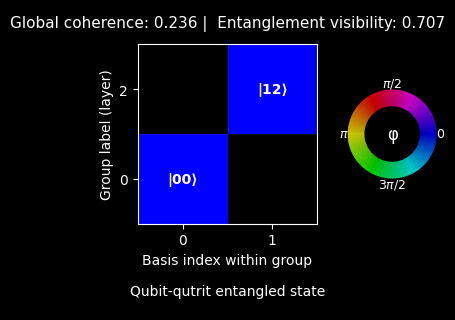

In [9]:

# 4.3 Hybrid qubit–qutrit entangled state: (|0,0> + |1,2>) / sqrt(2)
dims = [2,3]
psi_23_ent = normalize(basis((0,0), dims=dims) + basis((1,2), dims=dims))
plot_hld(psi_23_ent, dims=dims, show_metrics=True, caption="Qubit–qutrit entangled state")



## 5. Custom Groupings (Advanced)

You can pass a **callable** to `grouping` to define custom rows. For example: group by **parity** of the sum of levels.


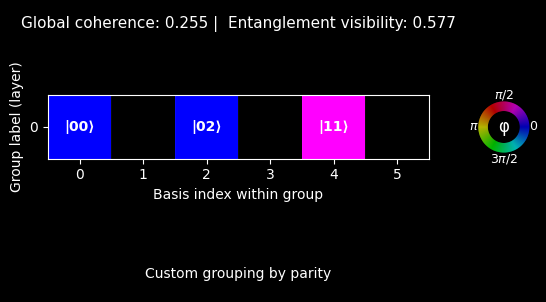

In [10]:

# 5.1 Parity‑grouped HLD for a 2×3 system with a patterned state
dims = [2,3]
psi_pattern = normalize(basis((0,0), dims=dims) + basis((0,2), dims=dims) + np.exp(1j*np.pi/3)*basis((1,1), dims=dims))
parity_grouping = lambda levels: "even" if (sum(levels) % 2 == 0) else "odd"

# Note: plot_hld should accept a callable grouping; if your implementation uses strings only,
# adapt plot_hld to accept callables mapping `levels -> row_label`.
plot_hld(psi_pattern, dims=dims, grouping=parity_grouping, show_metrics=True, caption="Custom grouping by parity")



## 6. Phase Patterns and Coherence

A **phase ramp** creates smooth hue gradients. Aligned hues within a row indicate high **intra‑row coherence**.


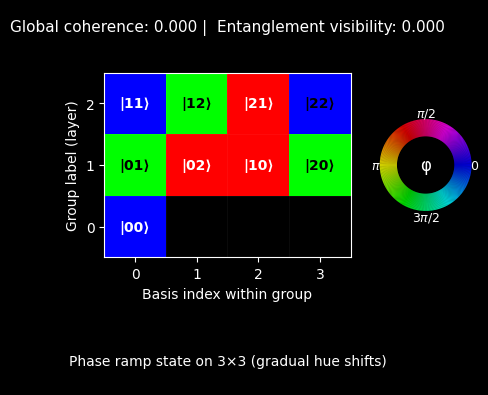

Global coherence spectrum (heuristic): 4.386954647137738e-17


In [11]:

# 6.1 Phase ramp over a 3×3 system
dims = [3,3]
psi_ramp = phases_ramp(dims, ramp_per_subsystem=[1.0, 2.0])
plot_hld(psi_ramp, dims=dims, show_metrics=True, caption="Phase ramp state on 3×3 (gradual hue shifts)")
m_ramp = compute_hld_metrics(psi_ramp, dims=dims)
print("Global coherence spectrum (heuristic):", m_ramp.get("global_coherence_spectrum"))



## 7. Reading Off Structure Quickly

Below are heuristic checks you can implement using `compute_hld_metrics` output:

- **Row probabilities** concentrated in a **single row** \(\Rightarrow\) product‑like along the chosen grouping.
- **Multiple rows** with strong amplitude and **aligned phases** across them \(\Rightarrow\) GHZ/cat‑like patterns.
- **Single row** with multiple bright columns \(\Rightarrow\) **W‑like** occupancy for qubits or analogous qudit structures.
- **High intra‑row coherence** and **low amplitude entropy** in a row \(\Rightarrow\) aligned phases and concentrated mass.
- **Large inter‑row correlation** values \(\Rightarrow\) stronger coupling across rows (often entanglement‑related, heuristic).


In [12]:

# 7.1 Compare product vs. entangled on simple heuristics
dims = [2,2]
examples = {
    "product_00": basis((0,0), dims=dims),
    "bell_phi_plus": normalize(basis((0,0), dims=dims) + basis((1,1), dims=dims))
}
for name, psi in examples.items():
    m = compute_hld_metrics(psi, dims=dims)
    print(f"\n{name}:")
    for key in ["row_probabilities", "intra_row_coherence", "amplitude_entropy",
                "inter_row_correlation_matrix", "entanglement_visibility_index",
                "global_coherence_spectrum"]:
        print(f"  {key}: {m.get(key)}")



product_00:
  row_probabilities: {0: 1.0, 1: 0.0, 2: 0.0}
  intra_row_coherence: {0: 1.0, 1: nan, 2: nan}
  amplitude_entropy: {0: -1.000088900581841e-12, 1: 0.0, 2: 0.0, 3: 0.0}
  inter_row_correlation_matrix: [[1.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
  entanglement_visibility_index: 1.0
  global_coherence_spectrum: 0.25

bell_phi_plus:
  row_probabilities: {0: 0.5000000000000001, 1: 0.0, 2: 0.5000000000000001}
  intra_row_coherence: {0: 1.0, 1: nan, 2: 1.0}
  amplitude_entropy: {0: 0.3465735902789726, 1: 0.0, 2: 0.0, 3: 0.3465735902789726}
  inter_row_correlation_matrix: [[0.25, 0.0, 0.25], [0.0, 0.0, 0.0], [0.25, 0.0, 0.25]]
  entanglement_visibility_index: 0.7071067811865476
  global_coherence_spectrum: 0.3535533905932738



## 8. Saving Figures (Paper‑Ready)

Use `save_path` to export a high‑DPI image with an optional caption.


In [13]:

# 8.1 Save an example figure
dims = [2,2]
psi = normalize(basis((0,0), dims=dims) + basis((1,1), dims=dims))
_ = analyze_and_plot_hld(
    psi,
    dims=dims,
    show_metrics=True,
    theme="light",
    caption="Two‑qubit Bell state (Φ+)",
    save_path="bell_hld_example.png"  # Saved next to your notebook runtime
)
print("Saved: bell_hld_example.png")


Saved: bell_hld_example.png



## 9. Tips & Appendix

- **Dims matter:** Always pass `dims` for qudits or heterogeneous systems (e.g., `[2,3]`).
- **Grouping choice:** For qubits, `grouping="excitation"` is intuitive. For qudits, consider **parity**, **sum of levels**, or a domain‑specific label.
- **Ordering:** `ordering="lex"` makes structural motifs easier to compare across experiments.
- **Numerical stability:** Normalize states to avoid misleading visuals/metrics.
- **Heuristics, not proofs:** Metrics like *entanglement visibility* are **heuristic** summaries—use with caution when making claims.



## 10. Cheatsheet — Reading HLDs Quickly

| State (name) | Dims | Definition | HLD Signature (Expected) | Quick Metrics Heuristics |
|---|---|---|---|---|
| product\_00 | [2,2] | \(|00\rangle\) | Single bright cell in the lowest row; uniform hue | Row probs concentrated in one row; low inter-row correlation |
| bell\_phi\_plus | [2,2] | \((|00\rangle+|11\rangle)/\sqrt{2}\) | Two bright cells in extreme rows; uniform hue within each | Multi-row mass; higher inter-row correlation; entanglement visibility ↑ |
| bell\_phi\_minus | [2,2] | \((|00\rangle-|11\rangle)/\sqrt{2}\) | Like Φ⁺ but with π hue flip between cells | As above; relative phase manifests as hue contrast |
| ghz3 | [2,2,2] | \((|000\rangle+|111\rangle)/\sqrt{2}\) | Two bright cells at W=0 and W=3 rows | Row mass at extremes; inter-row coupling ↑; EV index ↑ |
| w3 | [2,2,2] | \((|001\rangle+|010\rangle+|100\rangle)/\sqrt{3}\) | One row (W=1) with three bright columns; similar hue | Single-row mass; high intra-row coherence; distinct from GHZ |
| qutrit\_bell | [3,3] | \((|00\rangle+|11\rangle+|22\rangle)/\sqrt{3}\) | Diagonal motif across multiple rows; equal hues | Multi-row mass; EV index ↑ for qudits too |
| qutrit\_product\_phase | [3,3] | \(|0\rangle\otimes(|1\rangle+i|2\rangle)/\sqrt{2}\) | One column on first subsystem; two columns with phase contrast on second | Row mass biased; intra-row coherence moderate; not entangled |
| qubit\_qutrit\_ent\_02 | [2,3] | \((|0,0\rangle+|1,2\rangle)/\sqrt{2}\) | Two bright cells in distant rows; hue uniform within each | Inter-row coupling ↑; EV index ↑ |
| phase\_ramp\_3x3 | [3,3] | Smooth phase ramp over indices | Gradual hue gradient across rows/cols | Global coherence spectrum shows structured components |

**Tip:** Use this table as a mental map to predict **row occupancy**, **hue continuity**, and **metric signatures** before computing anything.


In [14]:

import pandas as pd

cheatsheet_rows = [
    ("product_00", "[2,2]", "|00>", "One bright cell (lowest row), uniform hue", "Row probs in one row; low inter-row corr"),
    ("bell_phi_plus", "[2,2]", "(|00>+|11>)/√2", "Two bright cells in extreme rows; uniform hue", "Multi-row mass; EV index ↑"),
    ("bell_phi_minus", "[2,2]", "(|00>-|11>)/√2", "Like Φ+ with π hue flip", "As Φ+; relative phase visible"),
    ("ghz3", "[2,2,2]", "(|000>+|111>)/√2", "Two bright cells at W=0 & W=3", "EV index ↑; inter-row corr ↑"),
    ("w3", "[2,2,2]", "(|001>+|010>+|100>)/√3", "One row (W=1), three bright cols", "High intra-row coherence; single-row mass"),
    ("qutrit_bell", "[3,3]", "(|00>+|11>+|22>)/√3", "Diagonal motif across rows", "EV index ↑ in qudits"),
    ("qutrit_product_phase", "[3,3]", "|0>⊗(|1>+i|2>)/√2", "Phase contrast on second subsystem", "Not entangled; moderate intra-row coh"),
    ("qubit_qutrit_ent_02", "[2,3]", "(|0,0>+|1,2>)/√2", "Two distant bright cells", "Inter-row coupling ↑; EV index ↑"),
    ("phase_ramp_3x3", "[3,3]", "phase ramp", "Hue gradient across grid", "Structured global coherence"),
]
df_cs = pd.DataFrame(cheatsheet_rows, columns=["state", "dims", "definition", "expected_HLD", "metric_heuristics"])

df_cs



,state,dims,definition,expected_HLD,metric_heuristics
0,product_00,"[2,2]",|00>,"One bright cell (lowest row), uniform hue",Row probs in one row; low inter-row corr
1,bell_phi_plus,"[2,2]",(|00>+|11>)/√2,Two bright cells in extreme rows; uniform hue,Multi-row mass; EV index ↑
2,bell_phi_minus,"[2,2]",(|00>-|11>)/√2,Like Φ+ with π hue flip,As Φ+; relative phase visible
3,ghz3,"[2,2,2]",(|000>+|111>)/√2,Two bright cells at W=0 & W=3,EV index ↑; inter-row corr ↑
4,w3,"[2,2,2]",(|001>+|010>+|100>)/√3,"One row (W=1), three bright cols",High intra-row coherence; single-row mass
5,qutrit_bell,"[3,3]",(|00>+|11>+|22>)/√3,Diagonal motif across rows,EV index ↑ in qudits
6,qutrit_product_phase,"[3,3]",|0>⊗(|1>+i|2>)/√2,Phase contrast on second subsystem,Not entangled; moderate intra-row coh
7,qubit_qutrit_ent_02,"[2,3]","(|0,0>+|1,2>)/√2",Two distant bright cells,Inter-row coupling ↑; EV index ↑
8,phase_ramp_3x3,"[3,3]",phase ramp,Hue gradient across grid,Structured global coherence


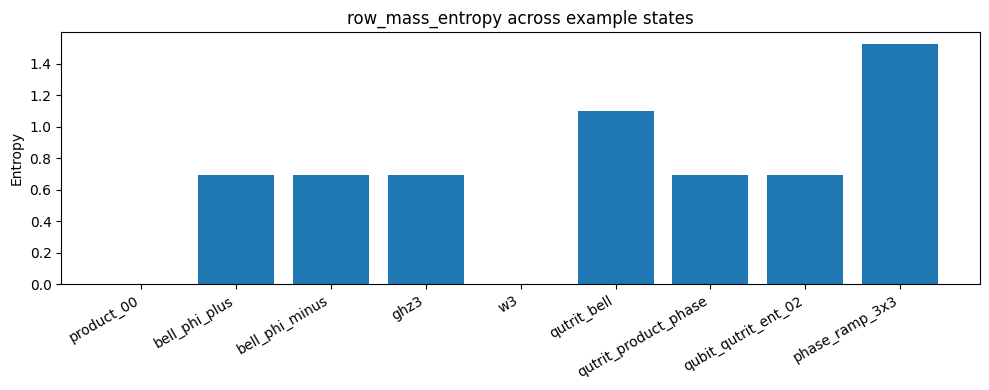

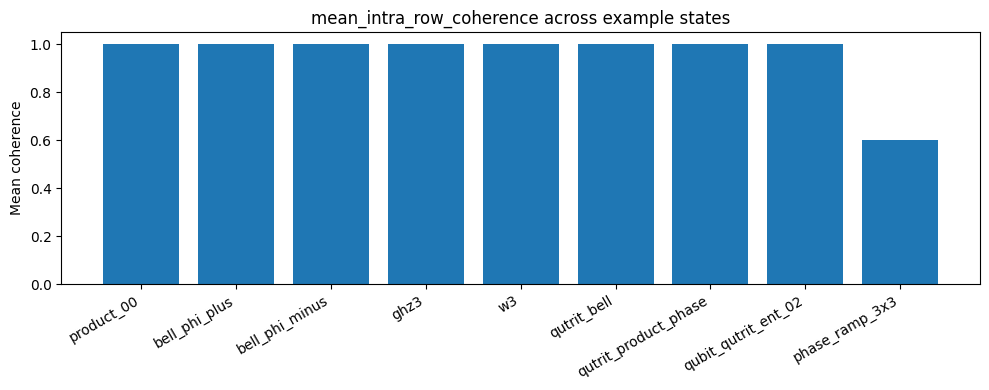

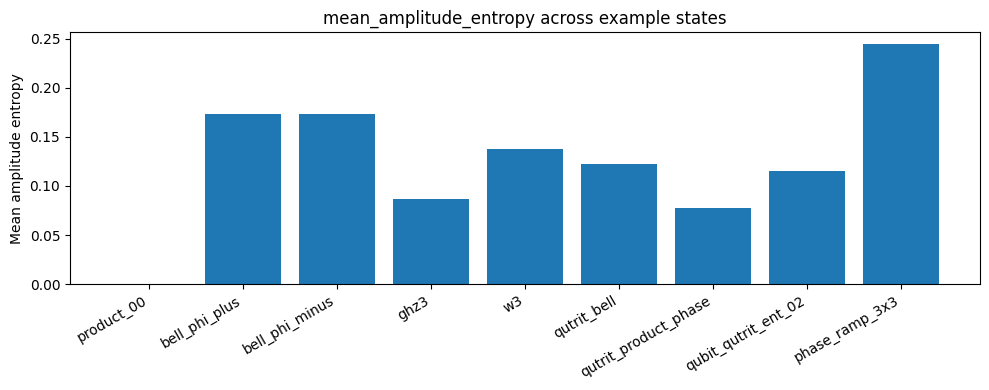

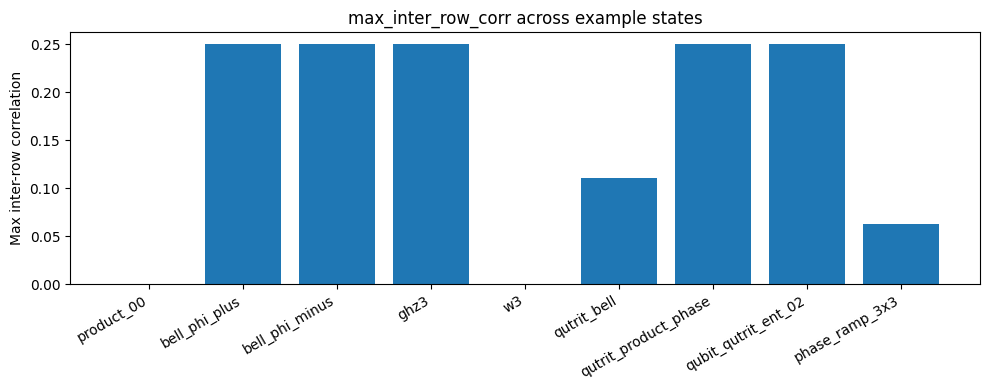

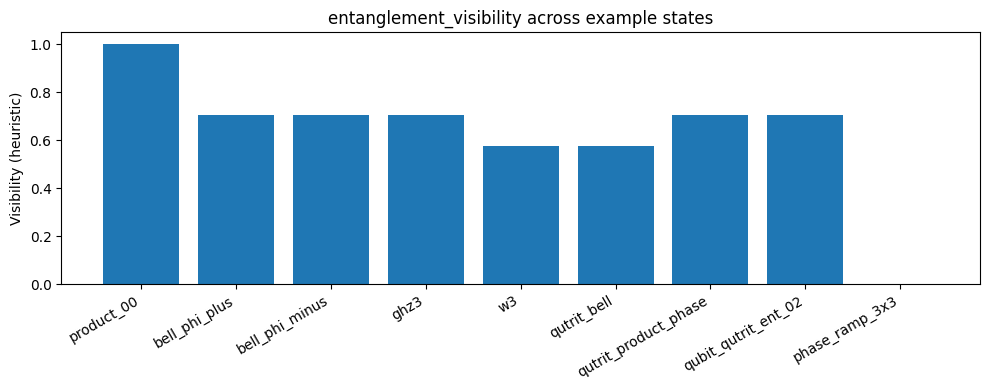

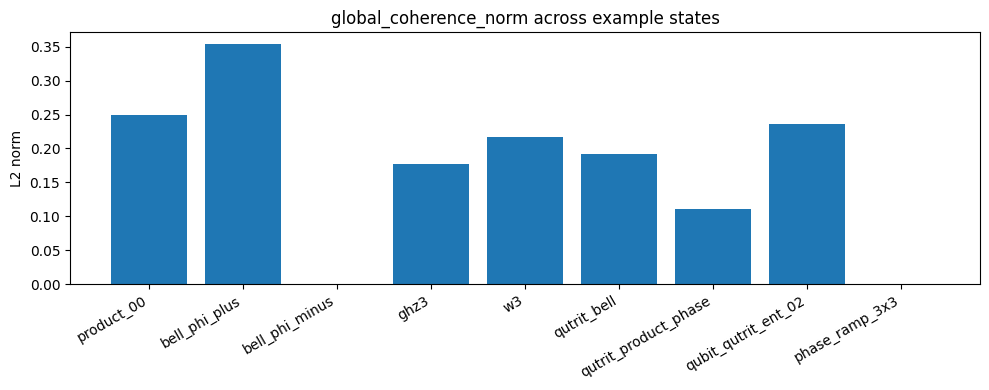

In [15]:

# 11. Metrics Dashboard — compare states with numeric summaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure HLD API is available (imported earlier in the notebook)
try:
    plot_hld, compute_hld_metrics
except NameError:
    from hld import plot_hld, compute_hld_metrics

# Helpers reused from earlier cells (redefine if user ran out-of-order)
def normalize(vec: np.ndarray) -> np.ndarray:
    vec = np.asarray(vec, dtype=complex).reshape(-1)
    nrm = np.linalg.norm(vec)
    if nrm == 0:
        raise ValueError("Zero vector cannot be normalized.")
    return vec / nrm

def dim_size(dims):
    s = 1
    for d in dims:
        s *= int(d)
    return s

def idx(*levels, dims):
    idx = 0
    for li, di in zip(levels, dims):
        idx = idx * di + li
    return idx

def basis(levels, dims):
    n = dim_size(dims)
    v = np.zeros(n, dtype=complex)
    v[idx(*levels, dims=dims)] = 1.0
    return v

def kron(*states):
    out = np.array([1.0+0j])
    for s in states:
        out = np.kron(out, np.asarray(s, dtype=complex))
    return out

def phases_ramp(dims, ramp_per_subsystem=None):
    if ramp_per_subsystem is None:
        ramp_per_subsystem = [1.0] * len(dims)
    n = dim_size(dims)
    state = np.zeros(n, dtype=complex)
    for flat in range(n):
        tuple_levels = []
        rem = flat
        for d in dims[::-1]:
            tuple_levels.append(rem % d)
            rem //= d
        tuple_levels = tuple_levels[::-1]
        phase = sum(ramp_per_subsystem[i] * tuple_levels[i] for i in range(len(dims)))
        state[flat] = np.exp(1j * 2 * np.pi * phase / max(dims))
    return normalize(state)

# Define example states spanning qubits & qudits
examples = [
    ("product_00", [2,2], basis((0,0), dims=[2,2])),
    ("bell_phi_plus", [2,2], normalize(basis((0,0), dims=[2,2]) + basis((1,1), dims=[2,2]))),
    ("bell_phi_minus", [2,2], normalize(basis((0,0), dims=[2,2]) - basis((1,1), dims=[2,2]))),
    ("ghz3", [2,2,2], normalize(basis((0,0,0), dims=[2,2,2]) + basis((1,1,1), dims=[2,2,2]))),
    ("w3", [2,2,2], normalize(basis((0,0,1), dims=[2,2,2]) + basis((0,1,0), dims=[2,2,2]) + basis((1,0,0), dims=[2,2,2]))),
    ("qutrit_bell", [3,3], normalize(basis((0,0), dims=[3,3]) + basis((1,1), dims=[3,3]) + basis((2,2), dims=[3,3]))),
    ("qutrit_product_phase", [3,3], kron(basis((0,), dims=[3]), normalize(basis((1,), dims=[3]) + 1j*basis((2,), dims=[3])))),
    ("qubit_qutrit_ent_02", [2,3], normalize(basis((0,0), dims=[2,3]) + basis((1,2), dims=[2,3]))),
    ("phase_ramp_3x3", [3,3], phases_ramp([3,3], ramp_per_subsystem=[1.0, 2.0])),
]

def summarize_metrics(m):
    # ----- Row Mass Entropy -----
    rp = m.get("row_probabilities", {})
    rp_arr = np.array(list(rp.values()), dtype=float)
    rp_arr = rp_arr[rp_arr > 0]
    row_mass_entropy = float(-(rp_arr * np.log(rp_arr)).sum()) if rp_arr.size else np.nan

    # ----- Mean Intra-row Coherence -----
    ir = m.get("intra_row_coherence", {})
    ir_vals = np.array(list(ir.values()), dtype=float)
    mean_intra_row_coherence = float(np.nanmean(ir_vals)) if ir_vals.size else np.nan

    # ----- Mean Amplitude Entropy -----
    ae = m.get("amplitude_entropy", {})
    ae_vals = np.array(list(ae.values()), dtype=float)
    mean_amplitude_entropy = float(np.nanmean(ae_vals)) if ae_vals.size else np.nan

    # ----- Max Inter-row Correlation -----
    C = np.array(m.get("inter_row_correlation_matrix", []), dtype=float)
    if C.ndim == 2 and C.size:
        off = C.copy()
        np.fill_diagonal(off, 0.0)
        max_inter_row_corr = float(np.nanmax(off))
    else:
        max_inter_row_corr = np.nan

    # ----- Entanglement Visibility -----
    entanglement_visibility = float(m.get("entanglement_visibility_index", np.nan))

    # ----- Global Coherence Norm -----
    global_coherence_norm = float(m.get("global_coherence_spectrum", np.nan))

    return {
        "row_mass_entropy": row_mass_entropy,
        "mean_intra_row_coherence": mean_intra_row_coherence,
        "mean_amplitude_entropy": mean_amplitude_entropy,
        "max_inter_row_corr": max_inter_row_corr,
        "entanglement_visibility": entanglement_visibility,
        "global_coherence_norm": global_coherence_norm,
    }

# Compute metrics for each example
rows = []
for name, dims, psi in examples:
    m = compute_hld_metrics(psi, dims=dims)
    s = summarize_metrics(m)
    s.update({"state": name, "dims": str(dims)})
    rows.append(s)

df = pd.DataFrame(rows).set_index("state")
# Compute metrics for each example
rows = []
for name, dims, psi in examples:
    m = compute_hld_metrics(psi, dims=dims)
    s = summarize_metrics(m)
    s.update({"state": name, "dims": str(dims)})
    rows.append(s)

df = pd.DataFrame(rows).set_index("state")

# Plot one metric per figure (no seaborn, single-plot figures, default colors)
def bar_metric(metric_key, ylabel):
    plt.figure(figsize=(10, 4))
    vals = df[metric_key].values
    plt.bar(df.index.tolist(), vals)
    plt.xticks(rotation=30, ha="right")
    plt.ylabel(ylabel)
    plt.title(f"{metric_key} across example states")
    plt.tight_layout()
    plt.show()

bar_metric("row_mass_entropy", "Entropy")
bar_metric("mean_intra_row_coherence", "Mean coherence")
bar_metric("mean_amplitude_entropy", "Mean amplitude entropy")
bar_metric("max_inter_row_corr", "Max inter-row correlation")
bar_metric("entanglement_visibility", "Visibility (heuristic)")
bar_metric("global_coherence_norm", "L2 norm")


In [16]:
df

,row_mass_entropy,mean_intra_row_coherence,mean_amplitude_entropy,max_inter_row_corr,entanglement_visibility,global_coherence_norm,dims
state,,,,,,,
product_00,-0.000000e+00,1.0,-2.500222e-13,0.000000,1.000000e+00,2.500000e-01,"[2, 2]"
bell_phi_plus,6.931472e-01,1.0,1.732868e-01,0.250000,7.071068e-01,3.535534e-01,"[2, 2]"
bell_phi_minus,6.931472e-01,1.0,1.732868e-01,0.250000,7.071068e-01,0.000000e+00,"[2, 2]"
ghz3,6.931472e-01,1.0,8.664340e-02,0.250000,7.071068e-01,1.767767e-01,"[2, 2, 2]"
w3,-2.220446e-16,1.0,1.373265e-01,0.000000,5.773503e-01,2.165064e-01,"[2, 2, 2]"
qutrit_bell,1.098612e+00,1.0,1.220680e-01,0.111111,5.773503e-01,1.924501e-01,"[3, 3]"
qutrit_product_phase,6.931472e-01,1.0,7.701635e-02,0.250000,7.071068e-01,1.111111e-01,"[3, 3]"
qubit_qutrit_ent_02,6.931472e-01,1.0,1.155245e-01,0.250000,7.071068e-01,2.357023e-01,"[2, 3]"
phase_ramp_3x3,1.522955e+00,0.6,2.441361e-01,0.062500,5.551115e-17,4.386955e-17,"[3, 3]"
